# BÁO CÁO THỰC HÀNH 2: HANDS-ON PRACTICE WITH PRE-TRAINED NEURAL NETWORK ARCHITECTURES

*   **Họ và tên:** Huỳnh Thế Hy
*   **MSSV:** 051205009083
---
## Mục tiêu

*   Làm quen với việc tải và sử dụng các mô hình pre-trained từ `torchvision.models`.
*   Hiểu cách tùy chỉnh và tinh chỉnh (fine-tune) các mô hình pre-trained cho các tác vụ cụ thể.
*   Sử dụng TensorBoard để theo dõi và trực quan hóa quá trình training.
*   Thực nghiệm với các kiến trúc và siêu tham số khác nhau để so sánh hiệu suất.

### 1. Thiết lập môi trường

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# 1. Thiết lập thiết bị
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda:0


## Bước 2 & 5: Chuẩn bị dữ liệu (Dataset)

Sử dụng bộ dữ liệu **CIFAR-10**, một bộ dữ liệu phổ biến cho bài toán phân loại ảnh. Bộ dữ liệu này bao gồm 60,000 ảnh màu 32x32 được chia thành 10 lớp, với 6,000 ảnh mỗi lớp.

Các bước:
1.  **Định nghĩa các phép biến đổi (transforms):**
    *   **Training set:** Áp dụng các kỹ thuật augmentation (lật ngang, cắt ngẫu nhiên) để tăng tính đa dạng của dữ liệu và giúp mô hình tổng quát hóa tốt hơn.
    *   **Test set:** Chỉ cần thay đổi kích thước và chuẩn hóa.
    *   Normalize dữ liệu để các giá trị pixel có cùng thang đo, giúp quá trình training ổn định.
2.  **Tải và tạo DataLoaders:** Sử dụng `torchvision.datasets.CIFAR10` để tải dữ liệu và `DataLoader` để tạo các batch dữ liệu cho việc training và testing.

In [9]:
# 2. Chuẩn bị dữ liệu với Augmentation mạnh hơn
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Train: Thêm ColorJitter để tăng tính đa dạng
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Augmentation thêm
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test: Giữ nguyên
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Dữ liệu đã sẵn sàng.")

Dữ liệu đã sẵn sàng.


3.  **Xây dựng hàm Training tối ưu**

In [10]:
def train_one_epoch(model, trainloader, criterion, optimizer, scheduler, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Step scheduler sau mỗi epoch
    if scheduler is not None:
        scheduler.step()

    train_acc = 100. * correct / total
    avg_loss = running_loss / len(trainloader)
    
    return avg_loss, train_acc

def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    acc = 100. * correct / total
    avg_loss = test_loss / len(testloader)
    return avg_loss, acc

def run_experiment(model, model_name, num_epochs, trainloader, testloader, device):
    print(f"\n--- Bắt đầu training {model_name} ---")
    
    # Sử dụng Label Smoothing để giảm Overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # SGD với Momentum và Weight Decay thường tốt hơn Adam cho CNN Classification
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    
    # Cosine Annealing Scheduler giúp hội tụ tốt hơn vào các epoch cuối
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, scheduler, epoch, device)
        test_loss, test_acc = evaluate(model, testloader, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.4f} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")
        
    print(f"--- Hoàn thành {model_name} sau {time.time() - start_time:.2f}s ---")
    return history

In [11]:
# 1. Tải ResNet18
model_resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# 2. CẢI TIẾN KIẾN TRÚC CHO CIFAR-10 (32x32 images)
# ResNet gốc dùng kernel 7x7 stride 2 và maxpool, làm mất thông tin ảnh nhỏ.
# Thay bằng kernel 3x3 stride 1 và bỏ maxpool.
model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_resnet.maxpool = nn.Identity() # Loại bỏ lớp maxpool đầu tiên

# 3. Thay đổi lớp Fully Connected cuối cùng
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)

# 4. Chuyển model sang thiết bị
model_resnet = model_resnet.to(device)

# 5. Chạy Training (Fine-tuning toàn bộ mạng)
# Số epoch nên để khoảng 30-50 để thấy hiệu quả rõ rệt của Scheduler
num_epochs = 30 
history_resnet = run_experiment(model_resnet, "ResNet-18 Modified", num_epochs, trainloader, testloader, device)


--- Bắt đầu training ResNet-18 Modified ---
Epoch 1/30 | LR: 0.0997 | Train Loss: 2.5189 Acc: 20.13% | Test Loss: 1.8658 Acc: 32.55%
Epoch 2/30 | LR: 0.0989 | Train Loss: 1.8655 Acc: 35.46% | Test Loss: 1.5925 Acc: 42.03%
Epoch 3/30 | LR: 0.0976 | Train Loss: 1.6755 Acc: 45.06% | Test Loss: 1.3923 Acc: 49.33%
Epoch 4/30 | LR: 0.0957 | Train Loss: 1.5117 Acc: 53.68% | Test Loss: 1.2690 Acc: 54.41%
Epoch 5/30 | LR: 0.0933 | Train Loss: 1.3367 Acc: 62.49% | Test Loss: 1.1327 Acc: 60.53%
Epoch 6/30 | LR: 0.0905 | Train Loss: 1.1874 Acc: 69.33% | Test Loss: 0.9280 Acc: 68.77%
Epoch 7/30 | LR: 0.0872 | Train Loss: 1.0817 Acc: 74.28% | Test Loss: 0.7716 Acc: 74.84%
Epoch 8/30 | LR: 0.0835 | Train Loss: 1.0193 Acc: 77.25% | Test Loss: 0.7603 Acc: 75.60%
Epoch 9/30 | LR: 0.0794 | Train Loss: 0.9737 Acc: 79.49% | Test Loss: 0.8093 Acc: 73.05%
Epoch 10/30 | LR: 0.0750 | Train Loss: 0.9381 Acc: 80.91% | Test Loss: 0.6071 Acc: 81.07%
Epoch 11/30 | LR: 0.0703 | Train Loss: 0.9107 Acc: 82.13% | Test

In [12]:
# 1. Tải VGG16 có Batch Normalization (Tốt hơn bản thường)
model_vgg = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)

# 2. Thay đổi lớp Classifier
# VGG giảm kích thước ảnh qua 5 lớp pool: 32 -> 16 -> 8 -> 4 -> 2 -> 1
# Lớp classifier gốc của VGG rất nặng (4096 nodes), ta có thể giữ nguyên hoặc thu gọn.
# Ở đây ta giữ cấu trúc nhưng thay lớp cuối cùng.
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, 10)

# 3. Chuyển model sang thiết bị
model_vgg = model_vgg.to(device)

# 4. Chạy Training (Full Fine-tuning)
# VGG thường tốn nhiều VRAM và tính toán hơn
history_vgg = run_experiment(model_vgg, "VGG-16 (BN)", num_epochs, trainloader, testloader, device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:03<00:00, 184MB/s] 



--- Bắt đầu training VGG-16 (BN) ---
Epoch 1/30 | LR: 0.0997 | Train Loss: 1.5687 Acc: 52.71% | Test Loss: 1.2655 Acc: 58.89%
Epoch 2/30 | LR: 0.0989 | Train Loss: 1.2441 Acc: 70.08% | Test Loss: 0.9495 Acc: 71.12%
Epoch 3/30 | LR: 0.0976 | Train Loss: 1.1284 Acc: 75.00% | Test Loss: 0.9920 Acc: 70.48%
Epoch 4/30 | LR: 0.0957 | Train Loss: 1.0863 Acc: 76.80% | Test Loss: 1.0022 Acc: 69.77%
Epoch 5/30 | LR: 0.0933 | Train Loss: 1.0416 Acc: 78.27% | Test Loss: 1.0234 Acc: 69.81%
Epoch 6/30 | LR: 0.0905 | Train Loss: 1.0272 Acc: 79.19% | Test Loss: 1.0995 Acc: 67.50%
Epoch 7/30 | LR: 0.0872 | Train Loss: 0.9924 Acc: 80.38% | Test Loss: 0.8251 Acc: 74.79%
Epoch 8/30 | LR: 0.0835 | Train Loss: 0.9735 Acc: 81.00% | Test Loss: 0.9400 Acc: 72.93%
Epoch 9/30 | LR: 0.0794 | Train Loss: 0.9505 Acc: 81.80% | Test Loss: 0.7607 Acc: 77.48%
Epoch 10/30 | LR: 0.0750 | Train Loss: 0.9263 Acc: 82.67% | Test Loss: 0.6925 Acc: 78.47%
Epoch 11/30 | LR: 0.0703 | Train Loss: 0.9059 Acc: 83.52% | Test Loss: 

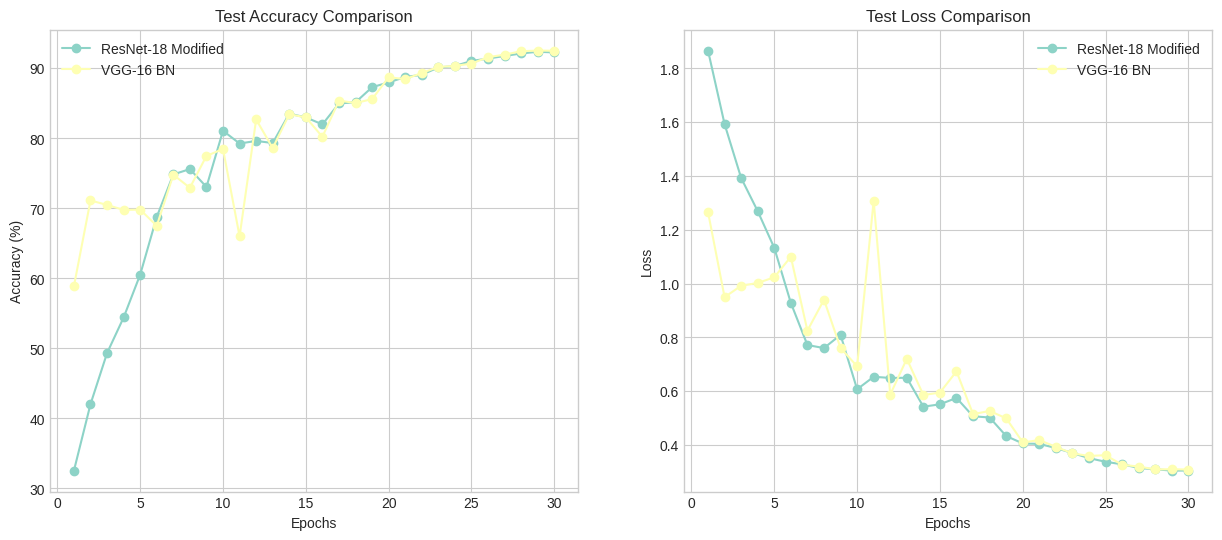

Best ResNet-18 Accuracy: 92.35%
Best VGG-16 Accuracy: 92.52%


In [13]:
def plot_history(histories, titles):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for hist, title in zip(histories, titles):
        epochs = range(1, len(hist['test_acc']) + 1)
        ax1.plot(epochs, hist['test_acc'], 'o-', label=f'{title}')
        ax2.plot(epochs, hist['test_loss'], 'o-', label=f'{title}')
    
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    ax2.set_title('Test Loss Comparison')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

plot_history([history_resnet, history_vgg], ["ResNet-18 Modified", "VGG-16 BN"])

# In kết quả tốt nhất
print(f"Best ResNet-18 Accuracy: {max(history_resnet['test_acc']):.2f}%")
print(f"Best VGG-16 Accuracy: {max(history_vgg['test_acc']):.2f}%")